# Dependendencies

In [2]:
import numpy as np
import pandas as pd
import plotnine as p9
from typing import List, Optional, Dict, Any
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
newPath = os.path.dirname(os.path.abspath(""))
if newPath not in sys.path:
    sys.path.append(newPath)
from BI import bi,jnp
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

m = bi(platform='cpu',cores=5)

jax.local_device_count 5


# Simulated function

In [3]:

def softmax(x: np.ndarray) -> np.ndarray:
    """
    Computes the softmax of a vector in a numerically stable way.
    """
    x = np.asarray(x)
    if x.size == 0:
        return np.array([])
        
    # Subtract max(x) for numerical stability
    exp_x = np.exp(x - np.nanmax(x))
    sum_exp_x = np.nansum(exp_x)

    # Handle cases where all exp_x become zero or if x was all NA
    if np.isnan(sum_exp_x) or sum_exp_x == 0:
        return np.full(x.shape, 1.0 / x.size)
    
    return exp_x / sum_exp_x

def simulate_social_interactions(
    N: int = 10,
    L: int = 10,
    T_steps: int = 100,
    p1_arg: List[float] = [0.4, 0.2, 0.3, 0.1],
    visits_arg: List[int] = [100, 100, 100, 100],
    sd_visits: float = 10.0,
    n_partners_max_lambda: float = 4.0,
    groupiness_mean: float = 0.3,
    groupiness_sd: float = 0.1,
    seed: Optional[int] = None,
    verbose: bool = False
) -> Dict[str, Any]:
    """
    Simulates individual visits to locations, distinguishing between
    solo visits and visits in association with other individuals.

    Args:
        N (int): Number of individuals.
        L (int): Number of locations.
        T_steps (int): Number of time steps (Note: not directly used in visit generation logic).
        p1_arg (List[float]): A set of predefined proportions for associated visits.
        visits_arg (List[int]): Corresponding total number of visits for locations
                                assigned each `p1_arg` value. Must be same length as `p1_arg`.
        sd_visits (float): Standard deviation for the normal distribution used to vary total visits.
        n_partners_max_lambda (float): Lambda parameter for the Poisson distribution
                                       used to determine the number of partners an individual
                                       attempts to associate with.
        groupiness_mean (float): Mean for the normal distribution from which
                                 association strengths (SRI values) are drawn.
        groupiness_sd (float): Standard deviation for the normal distribution
                               of association strengths.
        seed (Optional[int]): Optional random seed for reproducibility.
        verbose (bool): If True, prints validation details to the console and
                        includes them in the returned dictionary.

    Returns:
        A dictionary containing:
        - 'obs': A pandas DataFrame of all visits (i, j, site, time).
        - 'synthesis': A summary DataFrame with realized association proportions per site.
        - 'plot': A plotnine (ggplot) object summarizing the simulation.
        - 'sites': A DataFrame with details for each location (ID, p1, visits, type).
        - 'sri_matrix': The N x N numpy array of simulated association strengths.
        - 'N_assoc_draws': A numpy array of associated visits drawn per location.
        - 'validation_summary': If verbose=True, a list of dictionaries with validation stats.
    """
    if len(p1_arg) != len(visits_arg):
        raise ValueError("p1_arg and visits_arg must be of the same length.")

    # Set seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # --- 1. Define Location Characteristics ---
    picks = np.random.choice(len(p1_arg), size=L, replace=True)
    p1_sampled = np.array(p1_arg)[picks]
    visits_total = np.array(visits_arg)[picks]
    
    # Add random variations to total visits
    random_variations = np.random.normal(loc=visits_total, scale=sd_visits)
    visits_total = np.maximum(0, random_variations).astype(int)
    
    # Assign a type to each location based on which p1_arg was picked
    types = (np.arange(len(p1_arg)) + 1)[picks]

    df_locations = pd.DataFrame({
        'site': np.arange(1, L + 1),
        'p1': p1_sampled,
        'visits': visits_total,
        'type': types
    })

    # --- 2. Determine Number of Associated Visits per Location (Stochastic) ---
    # N_assoc is the number of dyadic association *events* planned for each location.
    N_assoc_planned = np.random.binomial(n=df_locations['visits'].values, p=df_locations['p1'].values)
    N_assoc_planned = np.minimum(N_assoc_planned, df_locations['visits'].values)

    # --- 3. Create SRI Matrix (Social Association Matrix) ---
    sri_mat = np.zeros((N, N))
    NID_py = np.arange(N)  # 0-based indices for individuals

    for ind_a in range(N):
        n_partners_count = np.random.poisson(lam=n_partners_max_lambda)
        n_partners_count = min(n_partners_count, N - 1)

        if n_partners_count > 0:
            available_partners = np.delete(NID_py, ind_a)
            if available_partners.size > 0:
                actual_sample_size = min(n_partners_count, len(available_partners))
                if actual_sample_size > 0:
                    selected_partners = np.random.choice(
                        available_partners, actual_sample_size, replace=False
                    )
                    sri_values = np.random.normal(
                        loc=groupiness_mean, scale=groupiness_sd, size=actual_sample_size
                    )
                    sri_mat[ind_a, selected_partners] = sri_values
    
    sri_mat = np.maximum(0, sri_mat) # SRI values must be non-negative

    # --- 4. Generate Associated Visit Data ---
    visits_assoc_list = []
    total_sri_sum = sri_mat.sum()

    for loc_idx in range(L): # 0-based location index
        n_assoc_for_loc = N_assoc_planned[loc_idx]
        if n_assoc_for_loc > 0 and total_sri_sum > 0:
            prob_flat = sri_mat.flatten() / total_sri_sum
            # Sample flattened indices, then convert back to 2D indices
            picked_flat_indices = np.random.choice(
                sri_mat.size, size=n_assoc_for_loc, p=prob_flat, replace=True
            )
            rows, cols = np.unravel_index(picked_flat_indices, sri_mat.shape)

            temp_df_assoc = pd.DataFrame({
                'i': rows + 1,       # Convert to 1-based ID
                'j': cols + 1,       # Convert to 1-based ID
                'site': loc_idx + 1, # Convert to 1-based ID
                'time': np.arange(1, n_assoc_for_loc + 1)
            })
            visits_assoc_list.append(temp_df_assoc)

    if visits_assoc_list:
        visits_assoc_df = pd.concat(visits_assoc_list, ignore_index=True)
    else:
        visits_assoc_df = pd.DataFrame(columns=['i', 'j', 'site', 'time'])

    # --- 5. Generate Solo Visit Data ---
    visits_solo_list = []
    # Calculate "social propensity" for each individual for solo visits
    sri_sums = sri_mat.sum(axis=1) + sri_mat.sum(axis=0) # row sums + col sums
    id_soc_propensity = softmax(sri_sums)

    for loc_idx in range(L):
        loc_id = loc_idx + 1 # 1-based location ID
        num_actual_assoc_for_loc = (visits_assoc_df['site'] == loc_id).sum()
        num_solo_to_generate = df_locations.loc[loc_idx, 'visits'] - num_actual_assoc_for_loc
        num_solo_to_generate = max(0, num_solo_to_generate)

        if num_solo_to_generate > 0:
            if id_soc_propensity.sum() > 0 and not np.all(np.isnan(id_soc_propensity)):
                picked_solo_individuals = np.random.choice(
                    NID_py, size=num_solo_to_generate, p=id_soc_propensity, replace=True
                )
            else: # Fallback to uniform sampling
                picked_solo_individuals = np.random.choice(
                    NID_py, size=num_solo_to_generate, replace=True
                )

            temp_df_solo = pd.DataFrame({
                'i': picked_solo_individuals + 1, # 1-based ID
                'j': picked_solo_individuals + 1, # For solo visits, i and j are the same
                'site': loc_id,
                'time': np.arange(1, num_solo_to_generate + 1)
            })
            visits_solo_list.append(temp_df_solo)

    if visits_solo_list:
        visits_solo_df = pd.concat(visits_solo_list, ignore_index=True)
    else:
        visits_solo_df = pd.DataFrame(columns=['i', 'j', 'site', 'time'])
        
    # --- 6. Combine Associated and Solo Visit Data ---
    all_visits_data = pd.concat([visits_assoc_df, visits_solo_df], ignore_index=True)

    # --- 7. Validation (Optional) ---
    validation_output_list = None
    if verbose:
        print("\n--- Corrected Validation ---")
        validation_output_list = []
        for loc_idx in range(L):
            loc_id = loc_idx + 1
            target_p1_val = df_locations.loc[loc_idx, 'p1']
            target_total_visits_val = df_locations.loc[loc_idx, 'visits']

            current_loc_data = all_visits_data[all_visits_data['site'] == loc_id]
            num_total_events_obs = len(current_loc_data)
            
            observed_p1_val = 0.0
            if num_total_events_obs > 0:
                num_associated_events_obs = (current_loc_data['i'] != current_loc_data['j']).sum()
                observed_p1_val = num_associated_events_obs / num_total_events_obs
            else:
                num_associated_events_obs = 0
            
            binom_realization_p1_val = 0.0
            if target_total_visits_val > 0:
                binom_realization_p1_val = N_assoc_planned[loc_idx] / target_total_visits_val
            
            loc_summary = {
                'location_id': loc_id,
                'target_p1': target_p1_val,
                'target_total_visits': target_total_visits_val,
                'N_assoc_from_binom': N_assoc_planned[loc_idx],
                'p1_from_binom_draw': binom_realization_p1_val,
                'observed_associated_events': num_associated_events_obs,
                'observed_total_events': num_total_events_obs,
                'observed_p1_in_data': observed_p1_val
            }
            validation_output_list.append(loc_summary)
            print(
                f"Location {loc_id:2d}: Target p1={target_p1_val:.2f} | "
                f"BinomialDraw p1={binom_realization_p1_val:.3f} | "
                f"OBSERVED p1={observed_p1_val:.3f} "
                f"({num_associated_events_obs:3d} Assoc / {num_total_events_obs:3d} Total Events)"
            )

    # --- 8. Post-processing and Plotting ---
    d = pd.merge(all_visits_data, df_locations[['site', 'type']], on='site', how='left')

    summary_rows = []
    if not d.empty:
        for site_id, group_df in d.groupby('site'):
            n_visits = len(group_df)
            n_solo = (group_df['i'] == group_df['j']).sum()
            p_assoc = (n_visits - n_solo) / n_visits if n_visits > 0 else 0
            
            summary_rows.append({
                'station': str(site_id),
                'N': n_visits,
                'proportion.of.associated.visits': p_assoc,
                'type': group_df['type'].iloc[0]
            })
    synthesis_df = pd.DataFrame(summary_rows)

    plot = (
        p9.ggplot(synthesis_df, p9.aes(
            x='proportion.of.associated.visits',
            y='N',
            color='factor(type)',
            label='station'
        ))
        + p9.geom_text()
        + p9.theme_minimal()
        + p9.theme(legend_position='none')
        + p9.labs(
            x="Proportion of associated visits",
            title="Simulated data"
        )
    )

    return {
        'obs': all_visits_data,
        'synthesis': synthesis_df,
        'plot': plot,
        'sites': df_locations.rename(columns={'site': 'location'}),
        'sri_matrix': sri_mat,
        'N_assoc_draws': N_assoc_planned,
        'validation_summary': validation_output_list
    }

## Test


--- Results ---

First 5 rows of observation data:
    i   j  site  time
0   9  35     1     1
1  13  11     1     2
2  48  49     1     3
3  15  38     1     4
4  23  27     1     5

Displaying plot...


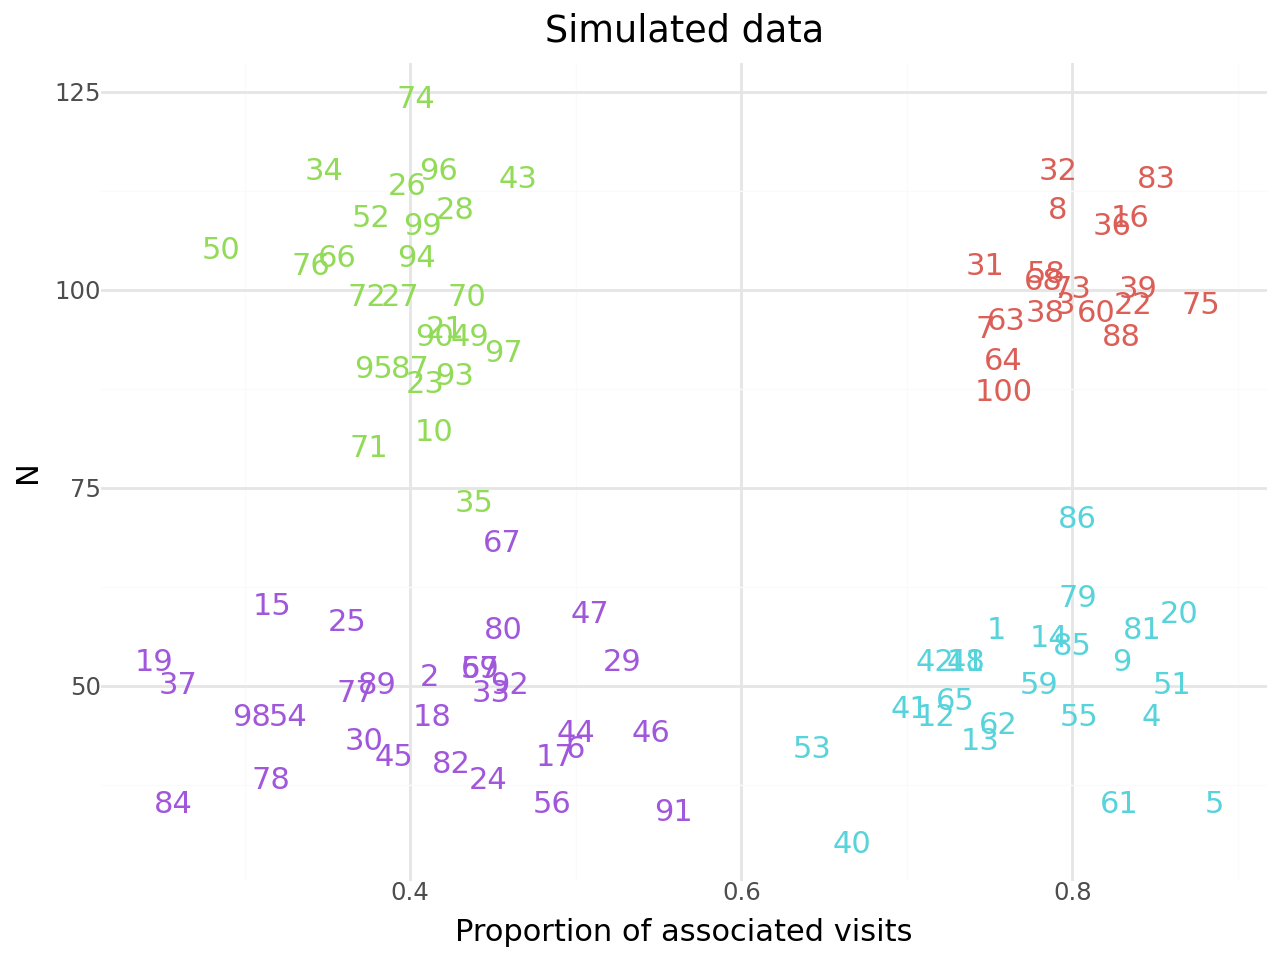

In [4]:
sim_results = simulate_social_interactions(
    N=50, L=100, T_steps=10,
    p1_arg=[0.8, 0.4,0.8, 0.4], visits_arg=[100, 100, 50, 50],
    n_partners_max_lambda=3, groupiness_mean=0.5, groupiness_sd=0.2,
    seed=42, verbose=False
)

print("\n--- Results ---")
print("\nFirst 5 rows of observation data:")
print(sim_results['obs'].head())


print("\nDisplaying plot...")
sim_results['plot']

# Model

In [5]:
import numpyro.distributions as Dist
import numpyro

def mix_weights(beta):
    beta1m_cumprod = jnp.cumprod(1.0 - beta, axis=-1)
    padded_beta = jnp.pad(beta, (0, 1), constant_values=1.0)
    padded_cumprod = jnp.pad(beta1m_cumprod, (1, 0), constant_values=1.0)
    return padded_beta * padded_cumprod

def dpmm(data, T=10):
    N, D = data.shape  # Number of features
    data_mean = jnp.mean(data, axis=0)
    data_std = jnp.std(data, axis=0)*2

    # 1) stick-breaking weights
    alpha = m.dist.gamma(1.0, 15.0,name='alpha')

    with numpyro.plate("beta_plate", T - 1):
        beta = numpyro.sample('beta', Dist.Beta(1, alpha))

    w = numpyro.deterministic("w",mix_weights(beta))


    # 2) component parameters
    with numpyro.plate("components", T):
        mu = m.dist.multivariatenormal(loc=data_mean, covariance_matrix=data_std*jnp.eye(D),name='mu')# shape (T, D)        
        sigma = m.dist.lognormal(0.0, 1.0,shape=(D,),event=1,name='sigma')# shape (T, D)
        Lcorr = m.dist.lkjcholesky(dimension=D, concentration=1.0,name='Lcorr')# shape (T, D, D)

        scale_tril = sigma[..., None] * Lcorr  # shape (T, D, D)

    # 3) Latent cluster assignments for each data point
    with numpyro.plate("data", N):
        # Sample the assignment for each data point
        z = numpyro.sample("z", Dist.Categorical(w)) # shape (N,)  

        numpyro.sample(
            "obs",
            Dist.MultivariateNormal(loc=mu[z], scale_tril=scale_tril[z]),
            obs=data
        )  

## Test

jax.local_device_count 16


/tmp/ipykernel_1439/91166456.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sosa/work/BI/BI/Main/main.py:192: FutureWarning: Some algorithms will automatically enumerate the discrete latent site z of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
sample: 100%|██████████| 1000/1000 [00:12<00:00, 77.60it/s, 31 steps of size 9.36e-02. acc. prob=0.77] 


Model found 4 clusters.


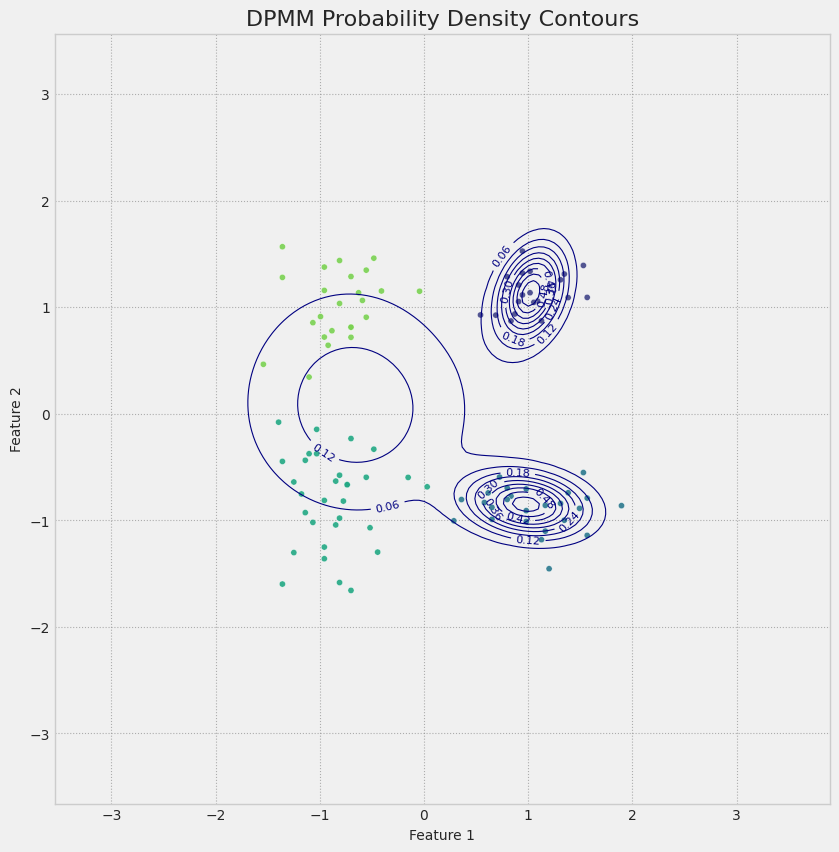

In [56]:
from sklearn.preprocessing import StandardScaler
m = bi(platform='cpu')
data=sim_results['synthesis'].iloc[:,[1,2]]
#data=jnp.array(sim_results['synthesis'].iloc[:,[1,2]].values)
#m.df = sim_results['synthesis']
#mean = jnp.mean(data, axis=0)
#std = jnp.std(data, axis=0)
#scaled_data = (data - mean) / std
#m.data_on_model = dict(data=scaled_data,T=10)
#m.fit(dpmm)
#m.plot(scaled_data,m.sampler,figsize=(10,10),point_size=20)
epsilon = 1e-6 
p = data['proportion.of.associated.visits'].clip(epsilon, 1 - epsilon)
data['proportion_logit'] = np.log(p / (1 - p))
data['N_log'] = np.log(data['N'] + 1)
X_transformed = data[['N_log', 'proportion_logit']].values
scaler = StandardScaler()
X_scaled_transformed = jnp.array(scaler.fit_transform(X_transformed))
m.data_on_model = dict(data=X_scaled_transformed,T=10)
m.fit(dpmm)
m.plot(scaled_data,m.sampler,figsize=(10,10),point_size=20)

# Scenarios functions

## Noise in probs

In [7]:
from BI.Models.dpmm import *
def scenario(
    Nsim=2,
    p1_arg= [0.5, 0.5, 0.5, 0.5],
    visits_arg= [100, 100, 100, 100],
    groupiness=0.5,
    low_N = 50,
    low_loc= 100,
    cluster_simulated=1
):
    m = bi(platform='cpu', cores=5)
    var_p1=m.dist.normal(jnp.array(p1_arg),scale=0.05,sample=True,shape=(Nsim,))
    var_visits=m.dist.normal(jnp.array(visits_arg), scale = 5,sample=True,shape=(Nsim,))
    var_groupiness=m.dist.normal(jnp.array(groupiness),scale=0.05,sample=True,shape=(Nsim,))

    var_N=low_N+m.dist.categorical(probs = 0.5 * jnp.ones(50),sample=True,shape=(Nsim,),seed=10)
    var_loc=low_loc+m.dist.categorical(probs = 0.5 * jnp.ones(100),sample=True,shape=(Nsim,),seed=10)

    N_cluster_predicted=[]
    for i in range(Nsim):
        print(f'Simulation {i+1} of {Nsim}')
        sim_results = simulate_social_interactions(
            N=var_N[i], L=var_loc[i],  T_steps=100,
            p1_arg=var_p1[i], visits_arg=var_visits[i],
            n_partners_max_lambda=3, groupiness_mean=var_groupiness[i], groupiness_sd=0.2,
            seed=42, verbose=False
        )
        #if plot:
        #    sim_results['plot'].show()

        data=jnp.array(sim_results['synthesis'].iloc[:,[1,2]].values)
        mean = jnp.mean(data, axis=0)
        std = jnp.std(data, axis=0)
        scaled_data = (data - mean) / std
        m.data_on_model = dict(data=scaled_data,T=10)
        m.fit(dpmm)

        post_mean_w, post_mean_mu, post_mean_cov, final_labels = predict_dpmm(scaled_data,m.sampler)
        N_cluster_predicted.append(len(jnp.unique(final_labels)))

        if N_cluster_predicted[-1] != cluster_simulated:
            m.plot(scaled_data,m.sampler,figsize=(10,10),point_size=20)

    df = pd.DataFrame({
    'predicted_clusters': N_cluster_predicted,
    'simulated_clusters': [cluster_simulated] * len(N_cluster_predicted)
    })
    return df


In [ ]:

print(f"Running scenario 1--------------------------–-–---------------–-")
res1=scenario(Nsim=100) # No differences
print(np.sum(res1.predicted_clusters.values != 1))
print(f"Running scenario 2--------------------------–-–---------------–-")
res2=scenario(
    Nsim=100,
    p1_arg= [0.8, 0.8, 0.4, 0.4],
    visits_arg= [50, 50, 100, 100],
    cluster_simulated=2
    )
print(np.sum(res2.predicted_clusters.values != 2))
print(f"Running scenario 3--------------------------–-–---------------–-")
res3=scenario(
    Nsim=100,
    p1_arg= [0.8, 0.4, 0.4, 0.8],
    visits_arg= [100, 100, 50, 50],
    cluster_simulated=4
    )
print(np.sum(res3.predicted_clusters.values != 4))

# Proportion of error rates

In [70]:
print(jnp.sum(res1['predicted_clusters'].values != 1)/res1.shape[0])
print(jnp.sum(res2['predicted_clusters'].values != 2)/res2.shape[0])
print(jnp.sum(res3['predicted_clusters'].values != 4)/res3.shape[0])

0.16
0.13
0.3
